In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

2022-03-29 21:49:51.658957: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
(train_data, train_labels), (test_data, test_labels) = datasets.mnist.load_data()

train_data = train_data / 255.0
test_data = test_data / 255.0

train_data = tf.pad(train_data, [[0, 0], [2, 2], [2, 2]])
test_data = tf.pad(test_data, [[0, 0], [2, 2], [2, 2]])

train_data = tf.expand_dims(train_data, 3)
test_data = tf.expand_dims(test_data, 3)

train_data = tf.repeat(train_data, repeats=3, axis=3)
test_data = tf.repeat(test_data, repeats=3, axis=3)

x_val = train_data[-2000:,:,:,:]
x_train = train_data[:-2000,:,:,:]
y_val = train_labels[-2000:]
y_train = train_labels[:-2000]

2022-03-29 21:49:58.698264: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-29 21:49:59.126276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-29 21:49:59.126687: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-29 21:49:59.213372: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-29 21:49:59.213948: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-29 21:49:59.233395: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library li

In [3]:
def inception(x, 
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, 1, padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, 1, padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, 1, padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, 1, padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, 1, padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D(3, strides=1, padding='same')(x)
  path4 = layers.Conv2D(filters_pool, 1, padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [5]:
input = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224,224,interpolation='bilinear', input_shape=x_train.shape[1:])(input)

x = layers.Conv2D(64, 7, padding='same', activation='relu')(input_tensor)
x = layers.MaxPool2D(3, strides=2, padding='same')(x)

x = layers.Conv2D(64, 1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = inception(x, 64, 96, 128, 16, 32, 32)
x = inception(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = inception(x, 192, 96, 208, 16, 48, 64)

aux1 = layers.AveragePooling2D(5, strides=3, padding='same')(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x, 160, 112, 224, 24, 64, 64)
x = inception(x, 128, 128, 256, 24, 64, 64)
x = inception(x, 112, 144, 288, 32, 64, 64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x, 256, 160, 320, 32, 128, 128)

x = layers.MaxPool2D(3, strides=2, padding='same')(x)

x = inception(x, 256, 160, 320, 32, 128, 128)
x = inception(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

out = layers.Dense(10, activation='softmax')(x)

In [6]:
model = Model(inputs=input, outputs=[out, aux1, aux2])

In [9]:
model.compile(optimizer='adam', loss=["sparse_categorical_crossentropy", 
                                        "sparse_categorical_crossentropy", 
                                        "sparse_categorical_crossentropy"], 
                                        metrics=["accuracy"])

In [10]:
history = model.fit(x_train, [y_train, y_train, y_train], epochs=10, 
                    batch_size=64, validation_data=(x_val, [y_val, y_val, y_val]))

2022-03-29 21:51:39.407910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-29 21:51:39.426208: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


Epoch 1/10


2022-03-29 21:51:48.970930: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-03-29 21:51:57.181529: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-03-29 21:52:11.512011: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-29 21:52:21.911824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


907/907 [==============================] - 355s 337ms/step - loss: 1.8905 - dense_4_loss: 1.2796 - dense_1_loss: 0.2967 - dense_3_loss: 0.3141 - dense_4_accuracy: 0.5373 - dense_1_accuracy: 0.9067 - dense_3_accuracy: 0.9008 - val_loss: 0.4406 - val_dense_4_loss: 0.3280 - val_dense_1_loss: 0.0542 - val_dense_3_loss: 0.0584 - val_dense_4_accuracy: 0.8950 - val_dense_1_accuracy: 0.9880 - val_dense_3_accuracy: 0.9865
Epoch 2/10
907/907 [==============================] - 288s 317ms/step - loss: 0.4445 - dense_4_loss: 0.2457 - dense_1_loss: 0.0940 - dense_3_loss: 0.1048 - dense_4_accuracy: 0.9264 - dense_1_accuracy: 0.9721 - dense_3_accuracy: 0.9694 - val_loss: 0.1986 - val_dense_4_loss: 0.1087 - val_dense_1_loss: 0.0461 - val_dense_3_loss: 0.0438 - val_dense_4_accuracy: 0.9725 - val_dense_1_accuracy: 0.9905 - val_dense_3_accuracy: 0.9900
Epoch 3/10
907/907 [==============================] - 289s 319ms/step - loss: 0.2951 - dense_4_loss: 0.1514 - dense_1_loss: 0.0699 - dense_3_loss: 0.0738 -

2022-03-29 22:18:24.416086: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


907/907 [==============================] - 311s 343ms/step - loss: 0.1770 - dense_4_loss: 0.0857 - dense_1_loss: 0.0432 - dense_3_loss: 0.0481 - dense_4_accuracy: 0.9736 - dense_1_accuracy: 0.9868 - dense_3_accuracy: 0.9854 - val_loss: 0.1376 - val_dense_4_loss: 0.0733 - val_dense_1_loss: 0.0339 - val_dense_3_loss: 0.0304 - val_dense_4_accuracy: 0.9820 - val_dense_1_accuracy: 0.9935 - val_dense_3_accuracy: 0.9930
Epoch 7/10
107/907 [==>...........................] - ETA: 4:34 - loss: 0.1293 - dense_4_loss: 0.0694 - dense_1_loss: 0.0295 - dense_3_loss: 0.0304 - dense_4_accuracy: 0.9779 - dense_1_accuracy: 0.9902 - dense_3_accuracy: 0.9905

2022-03-29 22:22:55.323676: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


591/907 [==================>...........] - ETA: 1:49 - loss: 0.1502 - dense_4_loss: 0.0735 - dense_1_loss: 0.0377 - dense_3_loss: 0.0390 - dense_4_accuracy: 0.9767 - dense_1_accuracy: 0.9892 - dense_3_accuracy: 0.9876

2022-03-29 22:25:42.643504: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


907/907 [==============================] - 314s 346ms/step - loss: 0.1540 - dense_4_loss: 0.0741 - dense_1_loss: 0.0386 - dense_3_loss: 0.0413 - dense_4_accuracy: 0.9770 - dense_1_accuracy: 0.9886 - dense_3_accuracy: 0.9874 - val_loss: 0.1507 - val_dense_4_loss: 0.0730 - val_dense_1_loss: 0.0423 - val_dense_3_loss: 0.0354 - val_dense_4_accuracy: 0.9815 - val_dense_1_accuracy: 0.9920 - val_dense_3_accuracy: 0.9915
Epoch 8/10
907/907 [==============================] - 312s 344ms/step - loss: 0.1408 - dense_4_loss: 0.0671 - dense_1_loss: 0.0363 - dense_3_loss: 0.0374 - dense_4_accuracy: 0.9790 - dense_1_accuracy: 0.9888 - dense_3_accuracy: 0.9889 - val_loss: 0.0974 - val_dense_4_loss: 0.0497 - val_dense_1_loss: 0.0288 - val_dense_3_loss: 0.0189 - val_dense_4_accuracy: 0.9850 - val_dense_1_accuracy: 0.9950 - val_dense_3_accuracy: 0.9960
Epoch 9/10
907/907 [==============================] - 313s 345ms/step - loss: 0.1247 - dense_4_loss: 0.0605 - dense_1_loss: 0.0310 - dense_3_loss: 0.0332 -

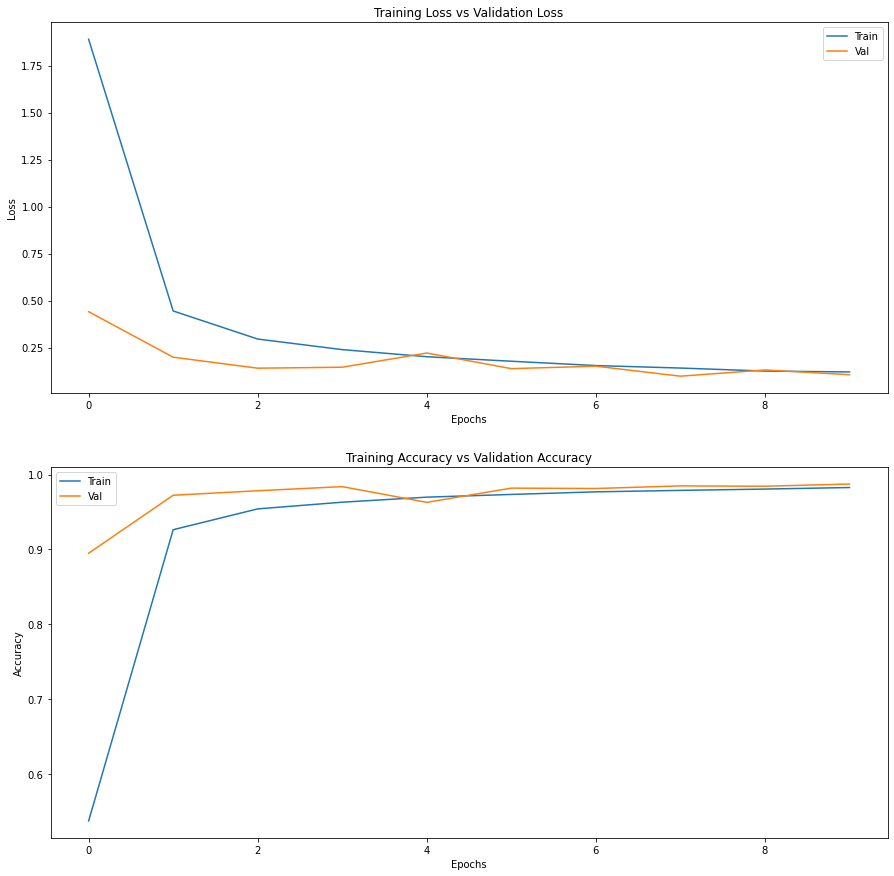

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [12]:
model.evaluate(test_data, [test_labels, test_labels, test_labels])

313/313 [==============================] - 41s 126ms/step - loss: 0.1020 - dense_4_loss: 0.0617 - dense_1_loss: 0.0192 - dense_3_loss: 0.0211 - dense_4_accuracy: 0.9819 - dense_1_accuracy: 0.9947 - dense_3_accuracy: 0.993127s - loss: 0.1323 - de


[0.10200109332799911,
 0.061719901859760284,
 0.019153373315930367,
 0.02112782746553421,
 0.9818999767303467,
 0.994700014591217,
 0.9930999875068665]